<a href="https://colab.research.google.com/github/evmpython/ERA5/blob/main/01_ERA5_GEE_mapa_TEMPERATURA_e_ANOMALIA_por_mes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


#  🟢 Mapa de Precipitação e Anomalia para `SETEMBRO de 2025` com os Dados do MERGE

---


 - Dados utilizados: [MERGE](http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_ACCUMULATED_YEARLY/)

 - Variável utilizada: pacum

 - Informações sobre os dados:
    - Resolução espacial: 10 km
    - Resolução temporal: mensal
    - Período dos dados: 1998-2025

 - Realizado e atualizado: Enrique V. Mattos - 08/10/2025



---



# Preparando o ambiente

In [54]:
# instalações
!pip install -q ultraplot cartopy salem rasterio pyproj geopandas

# importa bibliotecas
import ultraplot as uplt
import salem
import xarray as xr
import time
import pandas as pd
import glob
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# diretorios
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/MyDrive/PYHTON/00_GITHUB/16_LINKEDIN/04_precipitacao_merge'
dir_output = f'{dir}/output/codigo_03'
os.makedirs(dir_output, exist_ok=True)
#dir_output = '/content'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Baixando os dados
- Para baixar os dados mensais do MERGE de 1998 à 2025 demora 10 min.


In [ ]:
%%time
# link do FTP dos dados mensal
ftp = 'http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_ACCUMULATED_YEARLY/'

# define o nome dos meses
meses = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# loop das datas
for data in pd.date_range('19980101','20251231', freq='1M'):

    # extrai ano e mês
    ano = data.strftime('%Y')
    mes = data.strftime('%m')
    nome_mes = data.strftime('%B')[0:3].lower() # nome do mês no formato: jan, feb e etc

    print('-------------------------------------------------------------------------------------')
    print(f'BAIXANDO ARQUIVO: {ano}-{mes}')
    print('---------------------------------------------------------------------------------- \n')

    # monta nome do arquivo
    file = f'{ftp}MERGE_CPTEC_acum_{nome_mes}_{ano}.nc' # MERGE_CPTEC_acum_dec_2017.nc

    # baixa arquivo
    !wget {file} -P {dir_output}

A saída de streaming foi truncada nas últimas 5000 linhas.

--2025-10-08 16:37:04--  http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_ACCUMULATED_YEARLY/MERGE_CPTEC_acum_jan_2004.nc
Resolving ftp.cptec.inpe.br (ftp.cptec.inpe.br)... 150.163.178.56
Connecting to ftp.cptec.inpe.br (ftp.cptec.inpe.br)|150.163.178.56|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_ACCUMULATED_YEARLY/MERGE_CPTEC_acum_jan_2004.nc [following]
--2025-10-08 16:37:04--  https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_ACCUMULATED_YEARLY/MERGE_CPTEC_acum_jan_2004.nc
Connecting to ftp.cptec.inpe.br (ftp.cptec.inpe.br)|150.163.178.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3064112 (2.9M) [application/x-netcdf]
Saving to: ‘/content/drive/MyDrive/PYHTON/00_GITHUB/16_LINKEDIN/04_precipitacao_merge/output/codigo_03/MERGE_CPTEC_acum_jan

# Calcula anomalia
 - Demora 45.9 s.


In [58]:
%%time
# data
ano, mes = '2025', '09'
#ano, mes = '2023', '12'

# lista dos arquivos
#files = sorted(glob.glob('/content/MERGE_CPTEC_*.nc')) # /content/MERGE_CPTEC_acum_apr_1998.nc
files = sorted(glob.glob(f'{dir_output}/MERGE_CPTEC_*.nc')) # /content/MERGE_CPTEC_acum_apr_1998.nc

# lendo os dados
chuva_por_mes_1998_a_2025 = xr.open_mfdataset(files, concat_dim='time', combine='nested')

# ordenando o tempo
chuva_por_mes_1998_a_2025 = chuva_por_mes_1998_a_2025.sortby('time')

# leitura do shapefile do Brasil
shapefile_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')

# limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# CLIMATOLOGIA
climatologia = chuva_por_mes_1998_a_2025.sel(time=slice('1998-01-01','2020-12-01')).groupby("time.month").mean("time") # '1998-01-01T12:00:00.000000000' '1998-02-01T12:00:00.000000000'

# ANOMALIA
anomalia = chuva_por_mes_1998_a_2025.sel(time=slice(f'{ano}-{mes}-01',f'{ano}-{mes}-01')).groupby("time.month") - climatologia

# recorta o dado para região
anomalia = anomalia.salem.roi(shape=shapefile_brasil)
chuva_por_mes_1998_a_2025 = chuva_por_mes_1998_a_2025.salem.roi(shape=shapefile_brasil)

CPU times: user 13.5 s, sys: 346 ms, total: 13.8 s
Wall time: 19.3 s


In [47]:
# MENSAL
chuva_por_mes_1998_a_2025

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 333, lat: 691, lon: 551)
Coordinates:
  * lon      (lon) float64 4kB -85.05 -84.95 -84.85 ... -30.25 -30.15 -30.05
  * lat      (lat) float64 6kB -56.15 -56.05 -55.95 -55.85 ... 12.65 12.75 12.85
  * time     (time) datetime64[ns] 3kB 1998-01-01T12:00:00 ... 2025-09-01T12:...
Data variables:
    pacum    (time, lat, lon) float64 1GB dask.array<chunksize=(1, 691, 551), meta=np.ndarray>
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [48]:
# CLIMATOLOGIA
climatologia

<xarray.Dataset> Size: 37MB
Dimensions:  (month: 12, lat: 691, lon: 551)
Coordinates:
  * lon      (lon) float64 4kB -85.05 -84.95 -84.85 ... -30.25 -30.15 -30.05
  * lat      (lat) float64 6kB -56.15 -56.05 -55.95 -55.85 ... 12.65 12.75 12.85
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    pacum    (month, lat, lon) float64 37MB dask.array<chunksize=(1, 691, 551), meta=np.ndarray>

In [49]:
# ANOMALIA
anomalia

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 1, lat: 691, lon: 551)
Coordinates:
  * lon      (lon) float64 4kB -85.05 -84.95 -84.85 ... -30.25 -30.15 -30.05
  * lat      (lat) float64 6kB -56.15 -56.05 -55.95 -55.85 ... 12.65 12.75 12.85
  * time     (time) datetime64[ns] 8B 2025-09-01T12:00:00
    month    (time) int64 8B 9
Data variables:
    pacum    (time, lat, lon) float64 3MB dask.array<chunksize=(1, 691, 551), meta=np.ndarray>
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

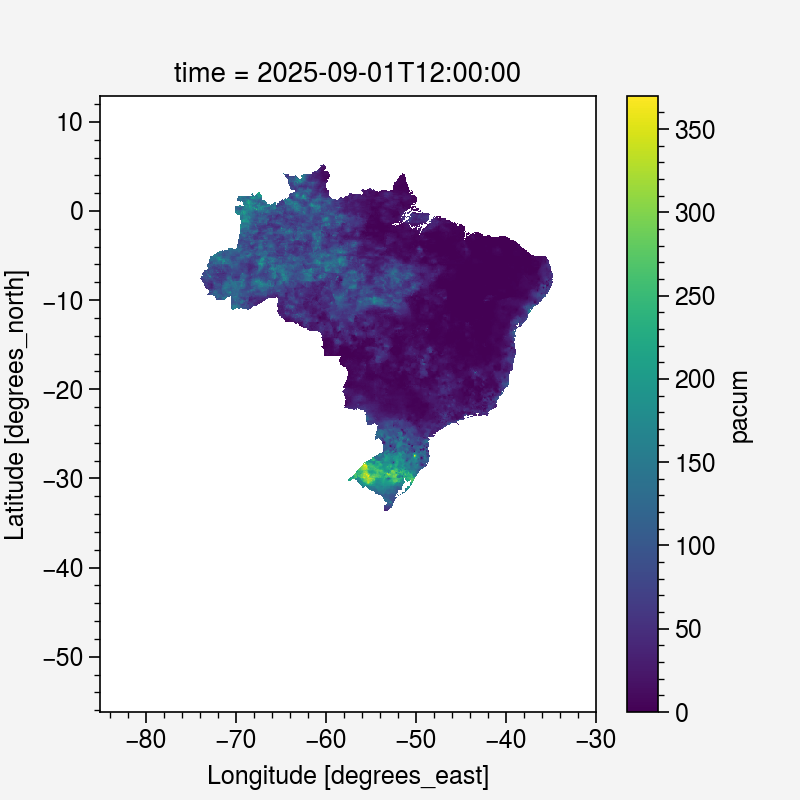

In [50]:
# plota gráfico simples
chuva_por_mes_1998_a_2025['pacum'].sel(time='2025-09-01T12:00:00.000000000').plot()

# Mapa de `TEMPERATURA` e `ANOMALIA`  

CPU times: user 11.5 s, sys: 167 ms, total: 11.6 s
Wall time: 18.7 s


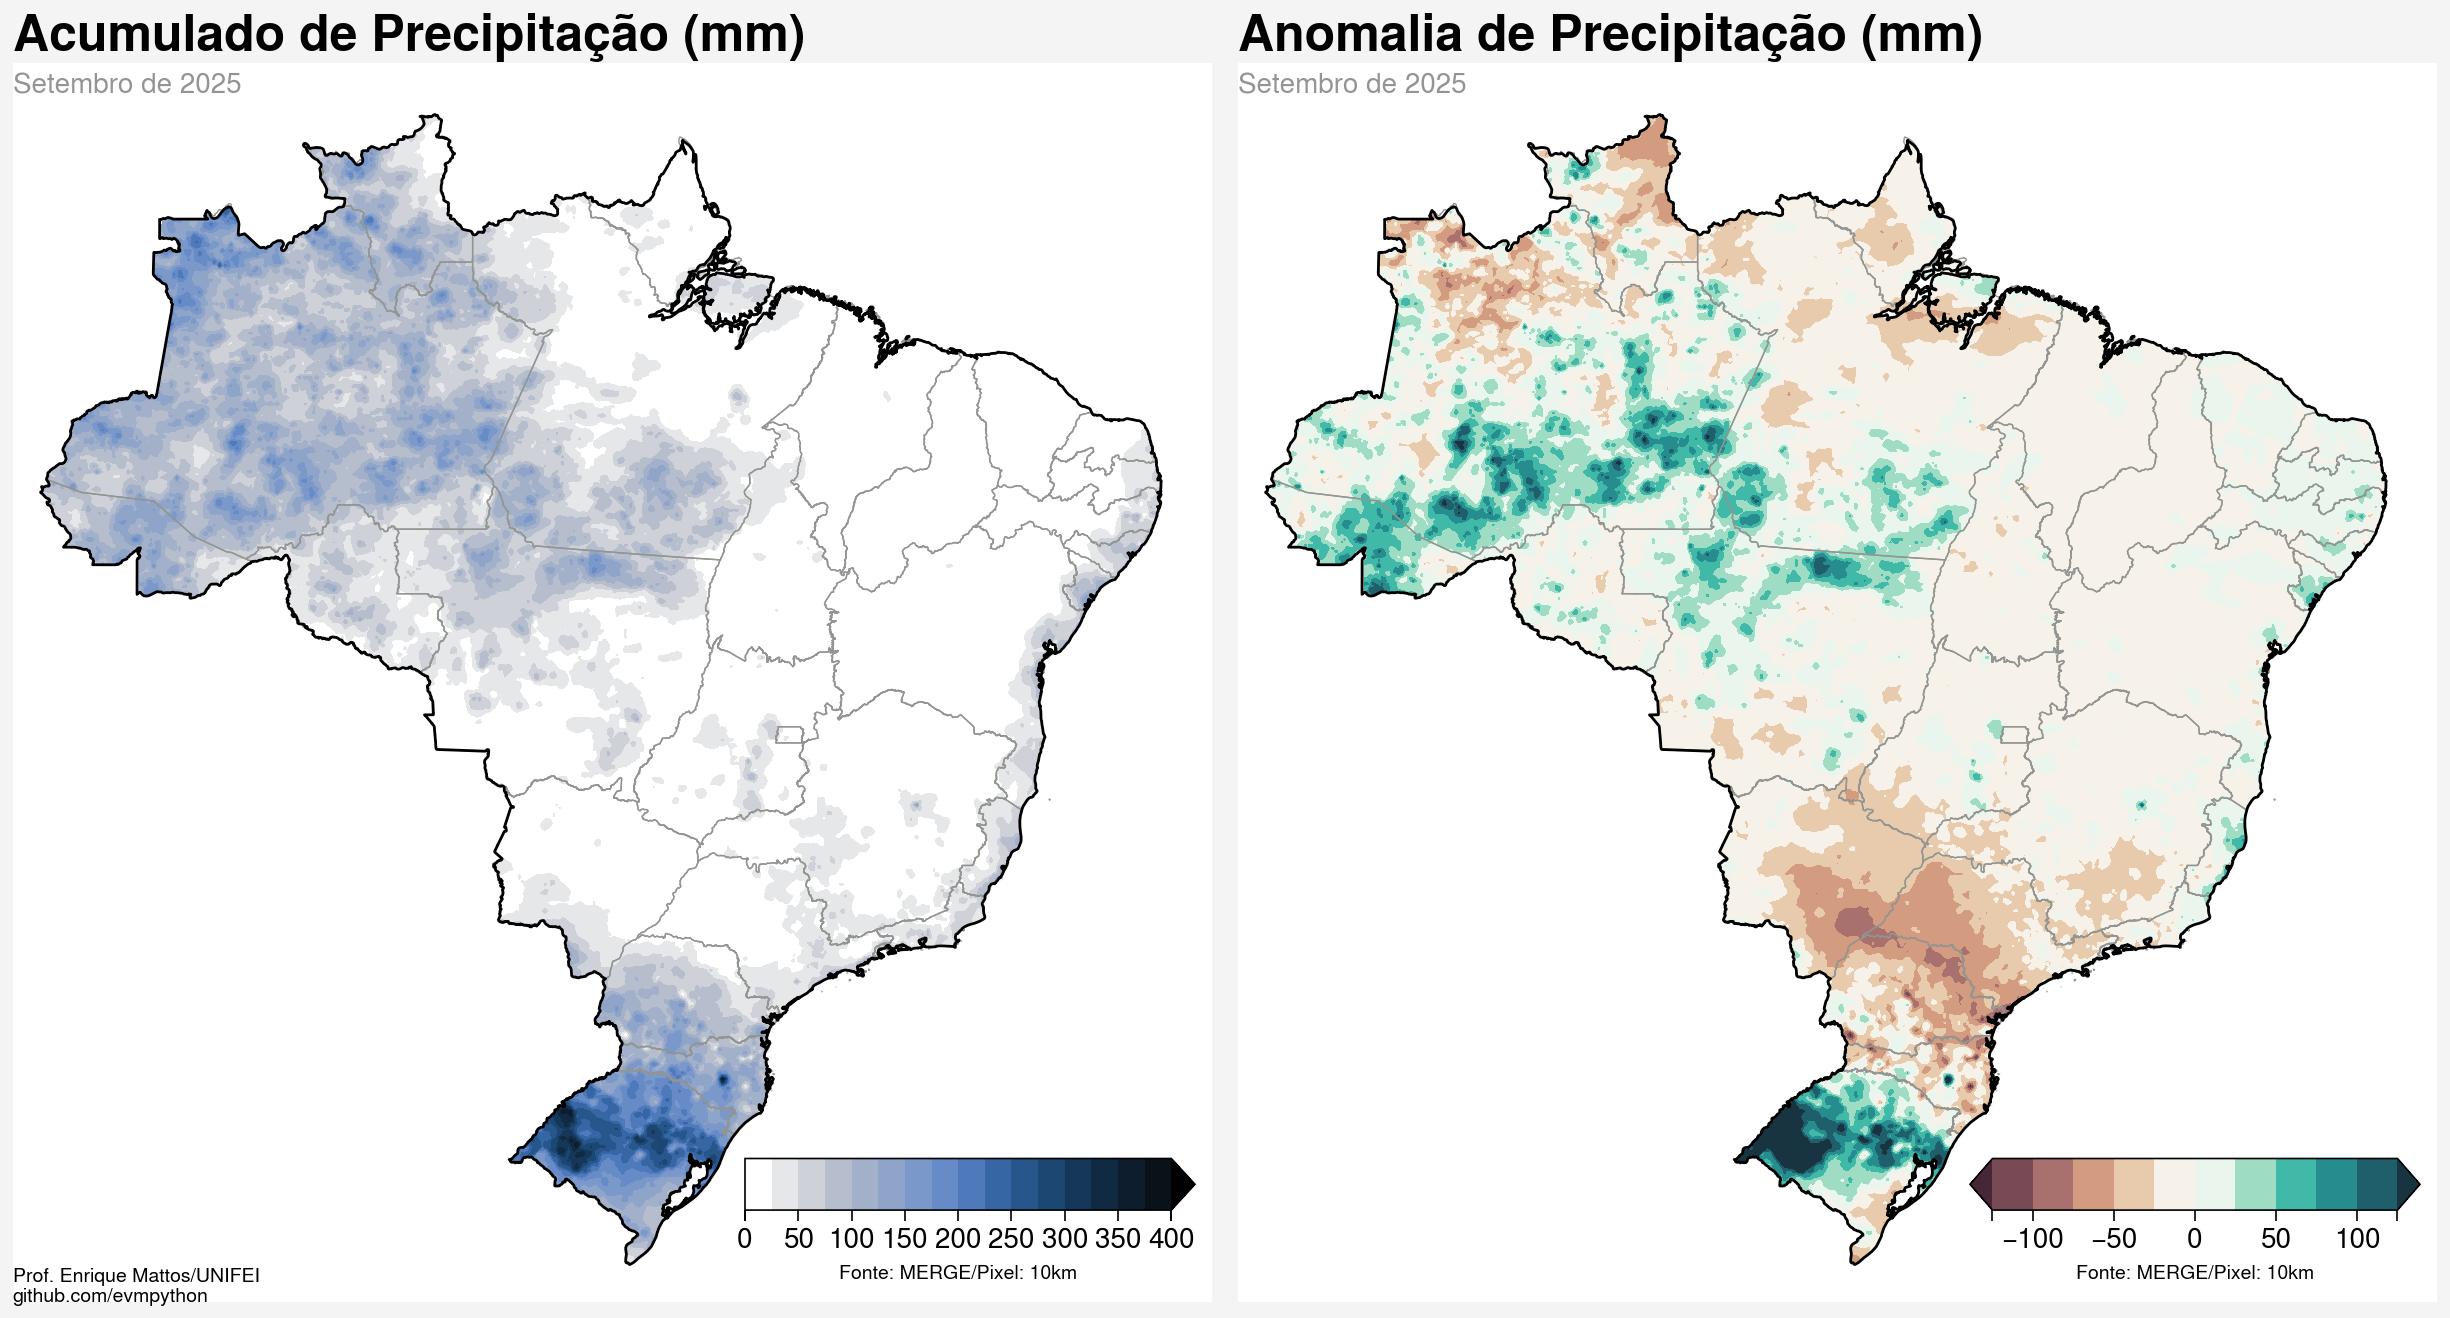

In [59]:
%%time
# cria a moldura da figura
fig, ax = uplt.subplots(axwidth=6, ncols=2, nrows=1, tight=True, proj='pcarree')

# define o nome dos meses
mes_dic =  {1: "Janeiro",
            2: "Fevereiro",
            3: "Março",
            4: "Abril",
            5: "Maio",
            6: "Junho",
            7: "Julho",
            8: "Augosto",
            9: "Setembro",
            10: "Outubro",
            11: "Novembro",
            12: "Dezembro"}
nome_mes = mes_dic[int(mes)]

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          small='20px', large='25px',
          linewidth=0, grid=False)

# plota subtítulo
ax.text(lonmin, latmax-1.0, f'{nome_mes} de {ano}', color='grey', fontsize=10)

#--------------------------------------------------------------#
#                     FIG-1: PRECIPITAÇÃO
#--------------------------------------------------------------#
# substituir zeros por NaN na variável 'pacum'
chuva_por_mes_1998_a_2025['pacum'] = chuva_por_mes_1998_a_2025['pacum'].where(chuva_por_mes_1998_a_2025['pacum'] != 0, np.nan)

# plota mapa
map1 = ax[0].contourf(chuva_por_mes_1998_a_2025['lon'],
                      chuva_por_mes_1998_a_2025['lat'],
                      chuva_por_mes_1998_a_2025['pacum'].loc[f'{ano}-{mes}-01'][0,:,:],
                      cmap='oslo_r',
                      vmin=0, vmax=400,
                      levels=uplt.arange(0, 400, 25),
                      extend='max',
                      colorbar='best',
                      colorbar_kw={'label': 'Fonte: MERGE/Pixel: 10km',
                                   'length': 18,
                                   'frameon': False,
                                   'ticklabelsize': 10,
                                   'labelsize': 7,
                                   'width': 2,
                                   'ticks': 50,
                                   'minorticks': False})

# título da figura
ax[0].format(title=f'Acumulado de Precipitação (mm)',
             titleloc='l',
             titleweight='bold',
             titlecolor='black')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[0])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])

# informação na figura
ax[0].annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

#--------------------------------------------------------------#
#                     FIG-2: ANOMALIA
#--------------------------------------------------------------#
# plota mapa
ax[1].contourf(anomalia['lon'],
               anomalia['lat'],
               anomalia['pacum'].loc[f'{ano}-{mes}-01'][0,:,:],
               cmap='DryWet',
               vmin=-125, vmax=125,
               levels=uplt.arange(-125, 125, 25),
               extend='both',
               colorbar='best',
               colorbar_kw={'label': 'Fonte: MERGE/Pixel: 10km',
                            'length': 18,
                            'frameon': False,
                            'ticklabelsize': 10,
                            'labelsize': 7,
                            'width': 2,
                            'ticks': 50,
                            'minorticks': False})

# título da figura
ax[1].format(title=f'Anomalia de Precipitação (mm)',
             titleloc='l',
             titleweight='bold',
             titlecolor='black')

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=0.5, alpha=1, ax=ax[1])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[1])

# salva figura
#fig.save(f'Fig_03_merge_precipitacao_e_anomalia_{ano}-{mes}.png', dpi=300)
fig.save(f'{dir_output}/Fig_03_merge_precipitacao_e_anomalia_{ano}-{mes}.png', dpi=300)